In [ ]:
# default_exp data.preparation

# Data preparation

> Functions required to prepare X (and y) from a pandas dataframe.

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.data.validation import *

In [ ]:
#export
def df2Xy(df, sample_col=None, feat_col=None, data_cols=None, target_col=None, to3d=True, splits=None, sort_by=None, ascending=True, y_func=None):
    r"""
    This function allows you to transform a pandas dataframe into X and y numpy arrays that can be used to craete a TSDataset.
    sample_col: column that uniquely identifies each sample.
    feat_col: used for multivariate datasets. It indicates which is the column that indicates the feature by row.
    data_col: indicates ths column/s where the data is located. If None, it means all columns (except the sample_col, feat_col, and target_col)
    target_col: indicates the column/s where the target is.
    to3d: turns X to 3d (including univariate time series)
    sort_by: used to indicate how to sort the dataframe.
    y_func: function used to calculate y for each sample (and target_col)
    """
    if feat_col is not None:
        assert sample_col is not None, 'You must pass a sample_col when you pass a feat_col'

    passed_cols = []
    sort_cols = []
    if sort_by is not None:
        if isinstance(sort_by, pd.core.indexes.base.Index): sort_by = sort_by.tolist()
        sort_cols += listify(sort_by)
    if sample_col is not None:
        if isinstance(sample_col, pd.core.indexes.base.Index): sample_col = sample_col.tolist()
        sample_col = listify(sample_col)
        sort_cols += listify(sample_col)
        passed_cols += sample_col
    if feat_col is not None:
        if isinstance(feat_col, pd.core.indexes.base.Index): feat_col = feat_col.tolist()
        feat_col = listify(feat_col)
        sort_cols += listify(feat_col)
        passed_cols += feat_col
    if data_cols is not None:
        if isinstance(data_cols, pd.core.indexes.base.Index): data_cols = data_cols.tolist()
        data_cols = listify(data_cols)
    if target_col is not None:
        if isinstance(target_col, pd.core.indexes.base.Index): target_col = target_col.tolist()
        target_col = listify(target_col)
        passed_cols += target_col

    if data_cols is None:
        data_cols = [col for col in df.columns if col not in passed_cols]
    if sort_cols:
        df.sort_values(sort_cols, ascending=ascending, inplace=True)

    # X
    X = df.loc[:, data_cols].values
    if X.dtype == 'O':
        X = X.astype(np.float32)
    if sample_col is not None:
        unique_ids = df[sample_col[0]].unique().tolist()
        n_samples = len(unique_ids)
    else:
        unique_ids = np.arange(len(df)).tolist()
        n_samples = len(df)
    if feat_col is not None:
        n_feats = df[feat_col[0]].nunique()
        X = X.reshape(n_samples, n_feats, -1)
    elif to3d:
        X = X.reshape(n_samples, 1, -1)

    # y
    if target_col is not None:
        if sample_col is not None: 
            y = []
            for tc in target_col:
                _y = np.concatenate(df.groupby(sample_col)[tc].apply(np.array).reset_index()[tc]).reshape(n_samples, -1)
                if y_func is not None: _y = y_func(_y)
                y.append(_y)
            y = np.concatenate(y, -1)
        else: 
            y = df[target_col].values
        y = np.squeeze(y)
    else:
        y = None

    # Output
    if splits is None: return X, y
    else: return split_xy(X, y, splits)
    

def split_Xy(X, y=None, splits=None):
    if splits is None: 
        if y is not None: return X, y
        else: return X
    if not is_listy(splits[0]): splits = [splits]
    else: assert not is_listy(splits[0][0]), 'You must pass a single set of splits.'
    _X = []
    _y = []
    for split in splits:
        _X.append(X[split])
        if y is not None: _y.append(y[split])
    if len(splits) == 1: return _X[0], _y[0]
    elif len(splits) == 2: return _X[0], _y[0], _X[1], _y[1]
    elif len(splits) == 3: return _X[0], _y[0], _X[1], _y[1], _X[2], _y[2]
    
df2xy = df2Xy
split_xy = split_Xy

In [ ]:
n_samples = 1_000
n_rows = 10_000

sample_ids = np.arange(n_samples).repeat(n_rows//n_samples).reshape(-1,1)
feat_ids = np.tile(np.arange(n_rows // n_samples), n_samples).reshape(-1,1)
cont = np.random.randn(n_rows, 6)
ind_cat = np.random.randint(0, 3, (n_rows, 1))
target = np.array(['a', 'b', 'c'])[ind_cat]
ind_cat2 = np.random.randint(0, 3, (n_rows, 1))
target2 = np.array(['a', 'b', 'c'])[ind_cat2]
data = np.concatenate([sample_ids, feat_ids, cont, target, target], -1)
columns = ['sample_id', 'feat_id'] + (np.arange(6) + 1).astype(str).tolist() + ['target'] + ['target2']
df = pd.DataFrame(data, columns=columns)
idx = np.random.choice(np.arange(len(df)), len(df), False)
new_dtypes = {'sample_id':np.int32, 'feat_id':np.int32, '1':np.float32, '2':np.float32, '3':np.float32, '4':np.float32, '5':np.float32, '6':np.float32}
df = df.astype(dtype=new_dtypes)
df = df.loc[idx].reset_index(drop=True)
df

,sample_id,feat_id,1,2,3,4,5,6,target,target2
0,913,0,0.516306,1.455767,-0.909085,0.343296,0.199469,1.438084,a,a
1,415,5,0.624918,2.710536,0.183670,0.902973,-0.562871,2.082113,c,c
2,223,8,-0.547221,1.420799,-0.231653,0.254948,0.332902,0.080678,a,a
3,133,4,2.061115,-0.012561,-0.443651,-0.186470,-0.267900,-1.643608,a,a
4,380,6,0.622229,2.023718,1.024886,-2.196236,-1.724978,-1.008602,b,b
...,...,...,...,...,...,...,...,...,...,...
9995,756,0,0.786480,0.288336,-1.594304,-0.151530,2.449426,-1.594877,a,a
9996,739,1,0.156989,-0.603900,0.323931,0.531661,0.037619,-1.310683,b,b
9997,564,1,0.980409,-0.686886,-0.312499,0.283499,-1.017951,-2.648084,a,a
9998,274,7,-0.801587,0.304059,-1.398204,1.769648,0.735717,-1.184793,a,a


In [ ]:
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='feat_id', data_cols=['1', '2', '3', '4', '5', '6'], target_col=['target'], y_func=y_func)
test_eq(X.shape, (1000, 10, 6))
test_eq(y.shape, (1000,))
rand_idx = np.random.randint(0, np.max(df.sample_id))
sorted_df = df.sort_values(by=['sample_id', 'feat_id']).reset_index(drop=True)
test_eq(X[rand_idx], sorted_df[sorted_df.sample_id == rand_idx][['1', '2', '3', '4', '5', '6']].values)
test_eq(np.squeeze(scipy.stats.mode(sorted_df[sorted_df.sample_id == rand_idx][['target']].values).mode), y[rand_idx])

In [ ]:
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='feat_id', target_col=['target', 'target2'], y_func=y_func)
test_eq(X.shape, (1000, 10, 6))
test_eq(y.shape, (1000, 2))
rand_idx = np.random.randint(0, np.max(df.sample_id))
sorted_df = df.sort_values(by=['sample_id', 'feat_id']).reset_index(drop=True)
test_eq(X[rand_idx], sorted_df[sorted_df.sample_id == rand_idx][['1', '2', '3', '4', '5', '6']].values)
test_eq(np.squeeze(scipy.stats.mode(sorted_df[sorted_df.sample_id == rand_idx][['target', 'target2']].values).mode), y[rand_idx])

In [ ]:
# Univariate
from io import StringIO
TESTDATA = StringIO("""sample_id;value_0;value_1;target
    rob;2;3;hot
    alice;6;7;lukewarm
    eve;11;12;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
X, y = df2Xy(df, sample_col='sample_id', target_col='target', data_cols=['value_0', 'value_1'], sort_by='sample_id')
test_eq(X.shape, (3, 1, 2))
test_eq(y.shape, (3,))
X, y

,sample_id,value_0,value_1,target
0,rob,2,3,hot
1,alice,6,7,lukewarm
2,eve,11,12,cold


(array([[[ 6,  7]],
 
        [[11, 12]],
 
        [[ 2,  3]]]),
 array(['lukewarm', 'cold', 'hot'], dtype=object))

In [ ]:
# Univariate
TESTDATA = StringIO("""sample_id;timestep;values;target
    rob;1;2;hot
    alice;1;6;lukewarm
    eve;1;11;cold
    
    rob;2;3;hot
    alice;2;7;lukewarm
    eve;2;12;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', target_col='target', data_cols=['values'], sort_by='timestep', to3d=True, y_func=y_func)
test_eq(X.shape, (3, 1, 2))
test_eq(y.shape, (3, ))
print(X, y)

,sample_id,timestep,values,target
0,rob,1,2,hot
1,alice,1,6,lukewarm
2,eve,1,11,cold
3,rob,2,3,hot
4,alice,2,7,lukewarm
5,eve,2,12,cold


[[[ 6 11]]

 [[ 2  7]]

 [[12  3]]] ['lukewarm' 'cold' 'hot']


In [ ]:
# Multivariate
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target
    rob;green;2;3;hot
    rob;yellow;3;4;hot
    rob;blue;4;5;hot
    rob;red;5;6;hot
    alice;green;6;7;lukewarm
    alice;yellow;7;8;lukewarm
    alice;blue;8;9;lukewarm
    alice;red;9;10;lukewarm
    eve;yellow;11;12;cold
    eve;green;10;11;cold
    eve;blue;12;12;cold
    eve;red;13;14;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
idx = np.random.choice(len(df), len(df), False)
df = df.iloc[idx]
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', target_col='target', data_cols=['value_0', 'value_1'], y_func=y_func)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3,))

,sample_id,trait,value_0,value_1,target
9,eve,green,10,11,cold
4,alice,green,6,7,lukewarm
1,rob,yellow,3,4,hot
8,eve,yellow,11,12,cold
2,rob,blue,4,5,hot
3,rob,red,5,6,hot
11,eve,red,13,14,cold
7,alice,red,9,10,lukewarm
6,alice,blue,8,9,lukewarm
10,eve,blue,12,12,cold


[[[ 8  9]
  [ 6  7]
  [ 9 10]
  [ 7  8]]

 [[12 12]
  [10 11]
  [13 14]
  [11 12]]

 [[ 4  5]
  [ 2  3]
  [ 5  6]
  [ 3  4]]] ['lukewarm' 'cold' 'hot']


In [ ]:
# Multivariate, multi-label
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target1;target2
    rob;green;2;3;hot;good
    rob;yellow;3;4;hot;good
    rob;blue;4;5;hot;good
    rob;red;5;6;hot;good
    alice;green;6;7;lukewarm;good
    alice;yellow;7;8;lukewarm;good
    alice;blue;8;9;lukewarm;good
    alice;red;9;10;lukewarm;good
    eve;yellow;11;12;cold;bad
    eve;green;10;11;cold;bad
    eve;blue;12;12;cold;bad
    eve;red;13;14;cold;bad
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', target_col=['target1', 'target2'], data_cols=['value_0', 'value_1'], y_func=y_func)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3, 2))
print(X, y)

,sample_id,trait,value_0,value_1,target1,target2
0,rob,green,2,3,hot,good
1,rob,yellow,3,4,hot,good
2,rob,blue,4,5,hot,good
3,rob,red,5,6,hot,good
4,alice,green,6,7,lukewarm,good
5,alice,yellow,7,8,lukewarm,good
6,alice,blue,8,9,lukewarm,good
7,alice,red,9,10,lukewarm,good
8,eve,yellow,11,12,cold,bad
9,eve,green,10,11,cold,bad


[[[ 8  9]
  [ 6  7]
  [ 9 10]
  [ 7  8]]

 [[12 12]
  [10 11]
  [13 14]
  [11 12]]

 [[ 4  5]
  [ 2  3]
  [ 5  6]
  [ 3  4]]] [['lukewarm' 'good']
 ['cold' 'bad']
 ['hot' 'good']]


In [ ]:
# Multivariate, unlabeled
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target
    rob;green;2;3;hot
    rob;yellow;3;4;hot
    rob;blue;4;5;hot
    rob;red;5;6;hot
    alice;green;6;7;lukewarm
    alice;yellow;7;8;lukewarm
    alice;blue;8;9;lukewarm
    alice;red;9;10;lukewarm
    eve;yellow;11;12;cold
    eve;green;10;11;cold
    eve;blue;12;12;cold
    eve;red;13;14;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
idx = np.random.choice(len(df), len(df), False)
df = df.iloc[idx]
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', data_cols=['value_0', 'value_1'], y_func=y_func)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y, None)

,sample_id,trait,value_0,value_1,target
4,alice,green,6,7,lukewarm
11,eve,red,13,14,cold
7,alice,red,9,10,lukewarm
10,eve,blue,12,12,cold
8,eve,yellow,11,12,cold
3,rob,red,5,6,hot
9,eve,green,10,11,cold
2,rob,blue,4,5,hot
1,rob,yellow,3,4,hot
0,rob,green,2,3,hot


[[[ 8  9]
  [ 6  7]
  [ 9 10]
  [ 7  8]]

 [[12 12]
  [10 11]
  [13 14]
  [11 12]]

 [[ 4  5]
  [ 2  3]
  [ 5  6]
  [ 3  4]]] None


In [ ]:
TESTDATA = StringIO("""sample_id;trait;timestep;values;target
    rob;green;1;2;hot
    rob;yellow;1;3;hot
    rob;blue;1;4;hot
    rob;red;1;5;hot
    alice;green;1;6;lukewarm
    alice;yellow;1;7;lukewarm
    alice;blue;1;8;lukewarm
    alice;red;1;9;lukewarm
    eve;yellow;1;11;cold
    eve;green;1;10;cold
    eve;blue;1;12;cold
    eve;red;1;13;cold
    
    rob;green;2;3;hot
    rob;yellow;2;4;hot
    rob;blue;2;5;hot
    rob;red;2;6;hot
    alice;green;2;7;lukewarm
    alice;yellow;2;8;lukewarm
    alice;blue;2;9;lukewarm
    alice;red;2;10;lukewarm
    eve;yellow;2;12;cold
    eve;green;2;11;cold
    eve;blue;2;13;cold
    eve;red;2;14;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', sort_by='timestep', target_col='target', data_cols=['values'], y_func=y_func)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3, ))

,sample_id,trait,timestep,values,target
0,rob,green,1,2,hot
1,rob,yellow,1,3,hot
2,rob,blue,1,4,hot
3,rob,red,1,5,hot
4,alice,green,1,6,lukewarm
5,alice,yellow,1,7,lukewarm
6,alice,blue,1,8,lukewarm
7,alice,red,1,9,lukewarm
8,eve,yellow,1,11,cold
9,eve,green,1,10,cold


[[[ 8  6]
  [ 9  7]
  [12 10]
  [13 11]]

 [[ 4  2]
  [ 5  3]
  [ 9  7]
  [10  8]]

 [[13 11]
  [14 12]
  [ 5  3]
  [ 6  4]]] ['lukewarm' 'cold' 'hot']


In [ ]:
# export
def df2np3d(df, groupby, data_cols=None):
    """Transforms a df (with the same number of rows per group in groupby) to a 3d ndarray"""
    if data_cols is None: data_cols = df.columns
    return np.stack([x[data_cols].values for _, x in df.groupby(groupby)]).transpose(0, 2, 1)

In [ ]:
user = np.array([1,2]).repeat(4).reshape(-1,1)
val = np.random.rand(8, 3)
data = np.concatenate([user, val], axis=-1)
df = pd.DataFrame(data, columns=['user', 'x1', 'x2', 'x3'])
test_eq(df2np3d(df, ['user'], ['x1', 'x2', 'x3']).shape, (2, 3, 4))

In [ ]:
# export
def add_missing_value_cols(df, cols=None, dtype=float):
    if cols is None: cols = df.columns
    elif not is_listy(cols): cols = [cols]
    for col in cols:
        df[f'missing_{col}'] = df[col].isnull().astype(dtype)
    return df

In [ ]:
data = np.random.randn(10, 2)
mask = data > .8
data[mask] = np.nan
df = pd.DataFrame(data, columns=['A', 'B'])
df = add_missing_value_cols(df, cols=None, dtype=float)
test_eq(df['A'].isnull().sum(), df['missing_A'].sum())
test_eq(df['B'].isnull().sum(), df['missing_B'].sum())
df

,A,B,missing_A,missing_B
0,-0.614729,-0.627753,0.0,0.0
1,0.223881,-0.972377,0.0,0.0
2,0.075731,-0.940629,0.0,0.0
3,0.354901,-2.430913,0.0,0.0
4,0.606703,-2.148233,0.0,0.0
5,NaN,-0.753488,1.0,0.0
6,NaN,-0.036325,1.0,0.0
7,-0.954861,0.534639,0.0,0.0
8,-0.716570,NaN,0.0,1.0
9,-0.505337,-1.006285,0.0,0.0


In [ ]:
# export
def add_missing_datetime(df, datetime_col, groupby=None, fill_value=np.nan, range_by_group=True, freq=None):
    """Fills missing datetime in a dataframe
    Args:
        df:                      pandas DataFrame
        datetime_col:            column tha contains the datetime data
        groupby:                 column used to identify unique_ids
        fill_value:              values that will be insert where missing dates exist. Default:np.nan
        range_by_group:          if True, dates will be filled between min and max dates for each group. Otherwise, between the min and max dates in the df.
        freq:                    frequence used to fillin the missing datetime
    """
    if is_listy(datetime_col): 
        assert len(datetime_col) == 1, 'you can only pass a single datetime_col'
        datetime_col = datetime_col[0]
    dates = pd.date_range(df[datetime_col].min(), df[datetime_col].max(), freq=freq)
    if groupby is not None:
        if is_listy(groupby): 
            assert len(groupby) == 1, 'you can only pass a single groupby'
            groupby = groupby[0]
        keys = df[groupby].unique()
        if range_by_group:
            # Fills missing dates between min and max for each unique id
            cols = df.columns
            min_dates = df.groupby(groupby)[datetime_col].min()
            max_dates = df.groupby(groupby)[datetime_col].max()
            idx_tuples = flatten_list([[(d, key) for d in pd.date_range(min_date, max_date)] for min_date, max_date, key in zip(min_dates, max_dates, keys)])
            multi_idx = pd.MultiIndex.from_tuples(idx_tuples, names=[datetime_col, groupby])
            df = df.set_index([datetime_col, groupby]).reindex(multi_idx, fill_value=np.nan).reset_index()
            df = df[cols]
        else:
            # Fills missing dates between min and max - same for all unique ids
            multi_idx = pd.MultiIndex.from_product((dates, keys), names=[datetime_col, groupby])
            df = df.set_index([datetime_col, groupby]).reindex(multi_idx, fill_value=np.nan)
            df = df.reset_index().sort_values(by=[groupby, datetime_col]).reset_index(drop=True)
    else: 
        index = pd.Index(pd.date_range(df[datetime_col].min(), df[datetime_col].max()), name=datetime_col)
        df = df.set_index([datetime_col]).reindex(index, fill_value=fill_value)
        df = df.reset_index().reset_index(drop=True)
    return df

In [ ]:
today = datetime.now()
dates = pd.date_range('2021-05-01', '2021-05-07')
dates2 = np.concatenate([dates[:3], dates[-2:]])
dates3 = pd.date_range(dates2.min(), dates2.max())
test_eq(dates, dates3)
data = np.zeros((len(dates2), 3))
data[:, 0] = dates2
data[:, 1] = np.random.rand(len(dates2))
data[:len(dates2)//2, 2] = np.random.randint(0,2,len(dates2)//2)
date_df = pd.DataFrame(data, columns=['date', 'a', 'key'])
date_df['date'] = pd.to_datetime(date_df['date'])
date_df

,date,a,key
0,2021-05-01,0.416850,1.0
1,2021-05-02,0.738152,1.0
2,2021-05-03,0.178315,0.0
3,2021-05-06,0.793299,0.0
4,2021-05-07,0.915250,0.0


In [ ]:
# Filling dates between min and max dates
add_missing_datetime(date_df, 'date')

,date,a,key
0,2021-05-01,0.416850,1.0
1,2021-05-02,0.738152,1.0
2,2021-05-03,0.178315,0.0
3,2021-05-04,NaN,NaN
4,2021-05-05,NaN,NaN
5,2021-05-06,0.793299,0.0
6,2021-05-07,0.915250,0.0


In [ ]:
# Filling dates between min and max dates for each value in groupby column
add_missing_datetime(date_df, 'date', groupby='key')

,date,a,key
0,2021-05-03,NaN,1.0
1,2021-05-04,NaN,1.0
2,2021-05-05,NaN,1.0
3,2021-05-06,NaN,1.0
4,2021-05-07,NaN,1.0
5,2021-05-01,NaN,0.0
6,2021-05-02,NaN,0.0


In [ ]:
# Filling dates between min and max dataframe dates for all values in groupby column
add_missing_datetime(date_df, 'date', groupby='key', range_by_group=False)

,date,key,a
0,2021-05-01,0.0,NaN
1,2021-05-02,0.0,NaN
2,2021-05-03,0.0,0.178315
3,2021-05-04,0.0,NaN
4,2021-05-05,0.0,NaN
5,2021-05-06,0.0,0.793299
6,2021-05-07,0.0,0.915250
7,2021-05-01,1.0,0.416850
8,2021-05-02,1.0,0.738152
9,2021-05-03,1.0,NaN


In [ ]:
# export
def time_gaps(data, dir='forward'):
    """Calculates time gaps to the next (forward) or last (backward) mask time steps. 
    This is based on the parse_delta used in:
    Cao, W., Wang, D., Li, J., Zhou, H., Li, L., & Li, Y. (2018). 
    Brits: Bidirectional recurrent imputation for time series. arXiv preprint arXiv:1805.10572.
    """
    mask = data.isnull().values.astype('float')
    if mask.ndim == 1: mask = mask.reshape(-1, 1)
    n_rows, n_vars = mask.shape
    if dir == 'backward':
        mask = mask[::-1]
    deltas = []
    for h in range(n_rows):
        if h == 0:
            deltas.append(np.ones(n_vars))
        else:
            deltas.append(np.ones(n_vars) + mask[h] * deltas[-1])
    output = np.array(deltas)
    if dir == 'backward':
        output = output[::-1]
    return output

def add_delta_cols(df, cols=None, groupby=None, forward=True, backward=True, nearest=True):
    if cols is None: cols = df.columns
    elif not is_listy(cols): cols = [cols]
    if forward or nearest: 
        if groupby:
            forward_time_gaps = np.concatenate(df[cols].groupby(df[groupby]).apply(lambda x: time_gaps(x, dir='forward')))
        else: 
            forward_time_gaps = time_gaps(df[cols], dir='forward')
        if forward : df[[f'{col}_delta_f' for col in cols]] = forward_time_gaps
    if backward or nearest:
        if groupby:
            backward_time_gaps = np.concatenate(df[cols].groupby(df[groupby]).apply(lambda x: time_gaps(x, dir='backward')))
        else:
            backward_time_gaps = time_gaps(df[cols], dir='backward')
        if backward: df[[f'{col}_delta_b' for col in cols]] = backward_time_gaps
    if nearest:
        df[[f'{col}_delta_n' for col in cols]] = np.stack([forward_time_gaps, backward_time_gaps]).min(axis=0)
    return df


In [ ]:
date_df = add_missing_datetime(date_df, 'date', groupby='key')
add_delta_cols(date_df, cols='a')

,date,a,key,a_delta_f,a_delta_b,a_delta_n
0,2021-05-03,NaN,1.0,1.0,7.0,1.0
1,2021-05-04,NaN,1.0,2.0,6.0,2.0
2,2021-05-05,NaN,1.0,3.0,5.0,3.0
3,2021-05-06,NaN,1.0,4.0,4.0,4.0
4,2021-05-07,NaN,1.0,5.0,3.0,3.0
5,2021-05-01,NaN,0.0,6.0,2.0,2.0
6,2021-05-02,NaN,0.0,7.0,1.0,1.0


In [ ]:
#export
# SlidingWindow vectorization is based on "Fast and Robust Sliding Window Vectorization with NumPy" by Syafiq Kamarul Azman
# https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5


def SlidingWindow(window_len:int, stride:Union[None, int]=1, start:int=0, get_x:Union[None, int, list]=None,  
                  get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, horizon:Union[int, list]=1, seq_first:bool=True, 
                  sort_by:Optional[list]=None, ascending:bool=True, check_leakage:bool=True):

    """
    Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
    Args:
        window_len      = length of lookback window
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
        horizon         = number of future datapoints to predict:
                            * 0 for last step in each sub-window. 
                            * n > 0 for a range of n future steps (1 to n). 
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y           = indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created (unlabeled data).
        y_func          = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by         = column/s used for sorting the array in ascending order
        ascending       = used in sorting
        check_leakage   = checks if there's leakage in the output between X and y
        
        
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """

    if horizon == 0: horizon_rng = np.array([0])
    elif is_listy(horizon): horizon_rng = np.array(horizon)
    elif isinstance(horizon, Integral): horizon_rng = np.arange(1, horizon + 1) if horizon > 0 else np.arange(horizon + 1, 1)
    min_horizon = min(horizon_rng)
    max_horizon = max(horizon_rng)
    _get_x = slice(None) if get_x is None else get_x.tolist() if isinstance(get_x, pd.core.indexes.base.Index) else [get_x] if not is_listy(get_x) else get_x
    _get_y = slice(None) if get_y is None else get_y.tolist() if isinstance(get_y, pd.core.indexes.base.Index) else [get_y] if not is_listy(get_y) else get_y
    if min_horizon <= 0 and y_func is None and get_y != [] and check_leakage: 
        assert get_x is not None and  get_y is not None and len([y for y in _get_y if y in _get_x]) == 0,  \
        'you need to change either horizon, get_x, get_y or use a y_func to avoid leakage'
    stride = ifnone(stride, window_len)

    def _inner(o):
        if not seq_first: o = o.T
        if isinstance(o, pd.DataFrame): 
            if sort_by is not None: o.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
            X = o.loc[:, _get_x].values if get_x is None or not isinstance(_get_x[0], Integral) else o.iloc[:, _get_x].values
            if get_y != []: y = o.loc[:, _get_y].values if get_y is None or not isinstance(_get_y[0], Integral) else o.iloc[:, _get_y].values
        else:
            if isinstance(o, torch.Tensor): o = o.numpy()
            if o.ndim < 2: o = o[:, None]
            X = o[:, _get_x]
            if get_y != []: y = o[:, _get_y]
        seq_len = len(X)
        X_max_time = seq_len - start - max_horizon - window_len + 1
        if X_max_time <= 0: return None, None
        X_sub_windows = (start + 
                         np.expand_dims(np.arange(window_len), 0) + # window len
                         np.expand_dims(np.arange(X_max_time, step=stride), 0).T) # # subwindows
        X = np.transpose(X[X_sub_windows], (0, 2, 1))   
        if get_y != [] and y is not None:
            y_start = start + window_len - 1
            y_max_time = seq_len - y_start - max_horizon
            y_sub_windows = (y_start + 
                             np.expand_dims(horizon_rng, 0) + # horizon_rng
                             np.expand_dims(np.arange(y_max_time, step=stride), 0).T) # # subwindows
            y = y[y_sub_windows]
            if y_func is not None and len(y) > 0: 
                y = y_func(y)
            if y.ndim >= 2: 
                for d in np.arange(1, y.ndim)[::-1]:
                    if y.shape[d] == 1: y = np.squeeze(y, axis=d)
            if y.ndim == 3: 
                y = y.transpose(0, 2, 1)
            return X, y
        else: return X, None
    return _inner

SlidingWindowSplitter = SlidingWindow

In [ ]:
wl = 5
t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl)(t)
test_eq(X.shape[1:], (1, wl))
itemify(X,)

input shape: (10,)


(#5) [(array([[0, 1, 2, 3, 4]]),),(array([[1, 2, 3, 4, 5]]),),(array([[2, 3, 4, 5, 6]]),),(array([[3, 4, 5, 6, 7]]),),(array([[4, 5, 6, 7, 8]]),)]

In [ ]:
wl = 5
h = 1

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9)]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=3, horizon=1, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[3, 4, 5, 6, 7]]), 8)]


In [ ]:
wl = 5
start = 3

t = np.arange(20)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=None, horizon=1, start=start)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)
[(array([[3, 4, 5, 6, 7]]), 8), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[13, 14, 15, 16, 17]]), 18)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=1, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9), (array([[5, 6, 7, 8, 9]]), 10), (array([[ 6,  7,  8,  9, 10]]), 11), (array([[ 7,  8,  9, 10, 11]]), 12), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[ 9, 10, 11, 12, 13]]), 14), (array([[10, 11, 12, 13, 14]]), 15), (array([[11, 12, 13, 14, 15]]), 16), (array([[12, 13, 14, 15, 16]]), 17), (array([[13, 14, 15, 16, 17]]), 18), (array([[14, 15, 16, 17, 18]]), 19)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var']).T
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None, seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
var,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), array([  5,  50, 500])), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), array([  6,  60, 600])), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), array([  7,  70, 700])), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), array([  8,  80, 800])), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), array([  9,  90, 900]))]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1, get_y=0)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), 5), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), 6), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), 7), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), 8), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), 9)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(wl, horizon=1, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

input shape: torch.Size([10, 3])


,var_0,var_1,target
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[ 0,  1,  2,  3,  4],
       [ 0, 10, 20, 30, 40]]), 500), (array([[ 1,  2,  3,  4,  5],
       [10, 20, 30, 40, 50]]), 600), (array([[ 2,  3,  4,  5,  6],
       [20, 30, 40, 50, 60]]), 700), (array([[ 3,  4,  5,  6,  7],
       [30, 40, 50, 60, 70]]), 800), (array([[ 4,  5,  6,  7,  8],
       [40, 50, 60, 70, 80]]), 900)]


(1000, 3)


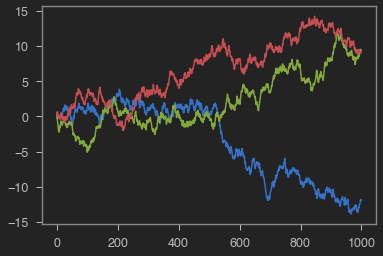

(200, 2, 5) (200,)


In [ ]:
n_vars = 3

t = (np.random.rand(1000, n_vars) - .5).cumsum(0)
print(t.shape)
plt.plot(t)
plt.show()
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=[0,1], get_y=2)(t)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

In [ ]:
wl = 5
n_vars = 3

t = (np.random.rand(100, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, horizon=0, get_x=columns[:-1], get_y='target')(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 3)


,var_0,var_1,target
0,0.431230,0.477595,0.459328
1,0.475764,0.131162,0.737657
2,0.354573,-0.154485,0.898112
3,-0.054309,0.185713,1.110838
4,0.114173,-0.308874,1.290260
...,...,...,...
95,-1.433672,-2.414882,-0.305033
96,-1.423498,-2.369802,-0.759593
97,-1.386295,-1.909611,-0.391660
98,-1.436132,-2.275568,-0.171837


(96, 2, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,var_0,var_1,var_2,var_3,target
0,-0.277627,-0.259756,0.223401,0.271753,-0.091595
1,-0.060366,-0.417492,0.219485,0.042390,-0.076915
2,-0.520374,-0.824907,0.388113,-0.349202,-0.055654
3,-0.388602,-0.408350,0.869714,-0.407647,-0.034628
4,-0.445069,-0.616753,0.502487,-0.067260,-0.477724
...,...,...,...,...,...
95,-3.259514,-1.966266,2.575463,-0.230634,0.582603
96,-3.383375,-2.387882,2.999895,-0.186500,0.229923
97,-3.300104,-2.768265,3.400721,0.169095,0.069022
98,-3.192817,-2.421795,3.532286,0.404467,0.074909


(96, 4, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5

t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,0.332362,0.699065,0.710538,1.138012,0.915894,0.668573,0.223766,0.573627,0.823657,0.905119,...,-2.640289,-2.748938,-2.343687,-2.454711,-2.058080,-1.590798,-1.268923,-0.846448,-0.898183,-0.926325
var_1,-0.026581,-0.275972,0.113229,0.554997,0.974721,0.502627,0.344004,0.002213,-0.295112,-0.556948,...,-1.107852,-1.471366,-1.510252,-1.999638,-1.752041,-1.961972,-2.402123,-2.281577,-2.305843,-2.058012
var_2,-0.331852,-0.667456,-0.359610,-0.031737,0.371183,0.784686,0.446702,0.488491,0.733589,0.437775,...,-0.586066,-0.690001,-0.568365,-0.687266,-0.486799,-0.899549,-1.121187,-0.988124,-0.947645,-1.406732
var_3,0.031012,0.401852,0.480733,0.470237,0.900710,0.694643,0.898483,1.126758,0.917998,1.390828,...,-0.959896,-0.701231,-0.213011,-0.619164,-0.447745,-0.000031,-0.013756,0.389712,0.869315,0.874761
target,-0.354637,-0.414439,-0.075433,0.027283,-0.001868,0.088725,0.008946,0.203827,0.478971,0.609537,...,2.534773,2.514984,2.701353,2.961456,2.567580,2.264981,2.294447,2.706729,2.696773,2.476168


(96, 4, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,-0.457616,-0.544390,-0.352934,-0.222590,0.241268,0.056922,0.308266,0.333158,0.269032,0.244962,...,-0.445991,-0.182928,-0.420216,-0.205921,-0.377687,-0.141663,0.071018,0.456181,0.752956,1.056633
var_1,0.239752,-0.009824,0.116582,-0.354314,0.006607,-0.219009,-0.140530,0.111803,0.289139,0.370788,...,-0.743959,-0.260083,-0.099541,-0.212556,-0.506749,-0.506829,-0.200632,-0.633212,-0.233882,-0.434408
var_2,-0.470451,-0.640481,-0.667894,-0.764481,-0.350376,-0.125020,-0.438858,-0.289906,-0.220174,0.206118,...,-2.035039,-1.580225,-1.602008,-2.096485,-1.749823,-1.428221,-1.231323,-0.842015,-1.035156,-1.332498
var_3,0.190090,0.040263,0.188431,-0.123704,-0.593026,-0.523533,-0.300541,-0.597201,-0.422791,-0.873605,...,0.710032,0.299885,0.378295,0.217006,-0.126821,-0.063251,-0.383307,-0.092504,-0.495022,-0.931424
target,-0.140794,-0.283998,0.076546,-0.332021,-0.117906,0.034880,-0.442004,-0.751818,-0.362297,-0.034618,...,-2.648656,-2.671027,-2.320827,-2.412657,-2.372594,-2.159858,-2.090725,-1.892646,-1.905535,-2.039749


(20, 4, 5) (20,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
splits = TrainValidTestSplitter(valid_size=.2, shuffle=False)(y)
X.shape, y.shape, splits

(100, 5)


,var_0,var_1,var_2,var_3,target
0,0.125704,-0.163152,0.073899,-0.488559,-0.421805
1,-0.113782,-0.625877,0.396930,-0.645519,-0.157495
2,0.171709,-0.927011,0.348951,-0.512059,-0.226929
3,0.497485,-1.366723,0.044576,-0.882065,-0.061826
4,0.522589,-1.838567,0.298239,-1.238373,-0.145567
...,...,...,...,...,...
95,-3.268875,-3.379593,2.533107,-2.035754,-2.437569
96,-2.920954,-3.540436,2.990629,-1.994627,-2.446094
97,-3.412568,-3.128439,3.407278,-1.861868,-2.473840
98,-3.898326,-2.704068,3.661842,-2.007301,-2.415793


((96, 4, 5),
 (96,),
 ((#77) [0,1,2,3,4,5,6,7,8,9...], (#19) [77,78,79,80,81,82,83,84,85,86...]))

In [ ]:
#export
def SlidingWindowPanel(window_len:int, unique_id_cols:list, stride:Union[None, int]=1, start:int=0, get_x:Union[None, int, list]=None,  
                       get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, horizon:Union[int, list]=1, seq_first:bool=True, 
                       sort_by:Optional[list]=None, ascending:bool=True, check_leakage:bool=True, return_key:bool=False, verbose:bool=True):

    """
    Applies a sliding window to a pd.DataFrame.
    
    Args:
        window_len      = length of lookback window
        unique_id_cols  = pd.DataFrame columns that will be used to identify a time series for each entity.
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
        horizon         = number of future datapoints to predict:
                            * 0 for last step in each sub-window. 
                            * n > 0 for a range of n future steps (1 to n). 
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y           = indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created (unlabeled data).
        y_func          = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by         = column/s used for sorting the array in ascending order
        ascending       = used in sorting
        check_leakage   = checks if there's leakage in the output between X and y
        return_key      = when True, the key corresponsing to unique_id_cols for each sample is returned
        
        
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """
    
    if not is_listy(unique_id_cols): unique_id_cols = [unique_id_cols]
    if sort_by is not None and not  is_listy(sort_by): sort_by = [sort_by]
    sort_by = unique_id_cols + (sort_by if sort_by is not None else [])
    
    def _SlidingWindowPanel(df):
        
        df.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
        unique_id_values = df[unique_id_cols].drop_duplicates().values
        _x = []
        _y = []
        _key = []
        for v in progress_bar(unique_id_values, display=verbose, leave=False):
            x_v, y_v = SlidingWindow(window_len, stride=stride, start=start, get_x=get_x, get_y=get_y, y_func=y_func, 
                                     horizon=horizon, seq_first=seq_first, 
                                     check_leakage=check_leakage)(df[(df[unique_id_cols].values == v).sum(axis=1) == len(v)])                                
            if x_v is not None and len(x_v) > 0: 
                _x.append(x_v)
                if return_key: _key.append([v.tolist()] * len(x_v))
                if y_v is not None and len(y_v) > 0: _y.append(y_v)
            else: 
                pv(f'cannot use {unique_id_cols} = {v} due to not having enough records', verbose)

        X = np.concatenate(_x)
        if _y != []:
            y = np.concatenate(_y)
            for d in np.arange(1, y.ndim)[::-1]:
                if y.shape[d] == 1: y = np.squeeze(y, axis=d)
        else: y = None
        if return_key: 
            key = np.concatenate(_key)
            if key.ndim == 2 and key.shape[-1] == 1: key = np.squeeze(key, -1)
            if return_key: return X, y, key
        else: return X, y
        
    return _SlidingWindowPanel

SlidingWindowPanelSplitter = SlidingWindowPanel

In [ ]:
samples = 100_000
wl = 5
n_vars = 10

t = (torch.stack(n_vars * [torch.arange(samples)]).T * tensor([10**i for i in range(n_vars)]))
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
df['time'] = np.arange(len(t))
df['device'] = 0
df['target'] = np.random.randint(0, 2, len(df))
df2 = df.copy()
df3 = df.copy()
cols = ['var_0', 'var_1', 'var_2', 'device', 'target']
df2[cols] = df2[cols] + 1
df3[cols] = df3[cols] + 2
df2 = df2.loc[:3]
df['region'] = 'A'
df2['region'] = 'A'
df3['region'] = 'B'
df = df.append(df2).append(df3).reset_index(drop=True)
df['index'] = np.arange(len(df))
df = df.sample(frac=1).reset_index(drop=True)
display(df.head())
df.shape

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,time,device,target,region,index
0,25065,250632,2506302,25063000,250630000,2506300000,25063000000,250630000000,2506300000000,25063000000000,25063,2,3,B,125067
1,36419,364172,3641702,36417000,364170000,3641700000,36417000000,364170000000,3641700000000,36417000000000,36417,2,3,B,136421
2,42426,424260,4242600,42426000,424260000,4242600000,42426000000,424260000000,4242600000000,42426000000000,42426,0,0,A,42426
3,16045,160432,1604302,16043000,160430000,1604300000,16043000000,160430000000,1604300000000,16043000000000,16043,2,2,B,116047
4,90642,906402,9064002,90640000,906400000,9064000000,90640000000,906400000000,9064000000000,90640000000000,90640,2,2,B,190644


(200004, 15)

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=False)(df)
X.shape, y.shape

cannot use ['device'] = [1] due to not having enough records


((199992, 10, 5), (199992,))

In [ ]:
X, y, key = SlidingWindowPanel(window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                               horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=True)(df)
X.shape, y.shape, key.shape

cannot use ['device'] = [1] due to not having enough records


((199992, 10, 5), (199992,), (199992,))

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True)(df)
X.shape, y.shape

cannot use ['device', 'region'] = [1 'A'] due to not having enough records


((199992, 10, 5), (199992,))

In [ ]:
# y_func must be a function applied to axis=1!
def y_max(o): return np.max(o, axis=1)

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          y_func=y_max, horizon=5, seq_first=True, sort_by=['time'], ascending=True)(df)
X.shape, y.shape

cannot use ['device', 'region'] = [1 'A'] due to not having enough records


((199982, 10, 5), (199982,))

In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 002b_data.unwindowed.ipynb.
Converted 002c_data.metadatasets.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 051_metrics.ipynb.
Converted 052_learner.ipynb.
Converted 052b_tslearner.ipynb.
Converted 053_optimizer.ipynb.
Converted 060_callback.core.ipynb.
Converted 061_callback.noisy_student.ipynb.
Converted 062_callback.gblend.ipynb.
Converted 063_callback.MVP.ipynb.
Converted 064_callback.PredictionDynamics.ipynb.
Converted 100_models.layers.ipynb.
Converted 100b_models.utils.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.Re